In [71]:
#!/usr/bin/env python
# coding: utf-8


import os
os.environ["PYTHONWARNINGS"] = "ignore"  # Suppress warnings

import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

from dimorphite_dl.dimorphite_dl import DimorphiteDL
from rdkit.Chem import AddHs
from rdkit.Chem import inchi
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import Standardizer
from rdkit.Chem import MolStandardize
from collections import Counter

def smiles_without_borders(smiles, pH=7.4, target= "Environment"):
    standardizer = Standardizer()
    smiles_original = smiles

    # Read SMILES and convert it to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    print("Input")
    display(Draw.MolToImage(mol))
 
    try:
        smiles_clean_counter = Counter()
        mol_dict = {}
        is_finalize = False

        for _ in range(5):
            
            #This solved phosphate oxidation in most cases but introduces a problem for some compounds: eg. geldanamycin where the stable strcutre is returned
            inchi_standardised = Chem.MolToInchi(mol)
            mol = Chem.MolFromInchi(inchi_standardised)
            
            print("Resolving Trial", _,)
            display(Draw.MolToImage(mol))
            
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
            mol = rdMolStandardize.Cleanup(mol) 
            # if many fragments, get the "parent" (the actual mol we are interested in) 
            mol = rdMolStandardize.FragmentParent(mol)
            # try to neutralize molecule
            uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
            
            mol = uncharger.uncharge(mol)# standardize molecules using MolVS and RDKit
            mol = standardizer.charge_parent(mol)
            mol = standardizer.isotope_parent(mol)
            mol = standardizer.stereo_parent(mol)
            
            print("Charge, Isotope and Stereo Parent")
            display(Draw.MolToImage(mol))
            
            #Normalize tautomers 
            #Method 1
            normalizer = MolStandardize.tautomer.TautomerCanonicalizer()
            mol = normalizer.canonicalize(mol)
            
            print("Tautomer Try 1")
            display(Draw.MolToImage(mol))
            
            #Method 2
            te = rdMolStandardize.TautomerEnumerator() # idem
            mol = te.Canonicalize(mol)
            
            print("Tautomer Try 2")
            display(Draw.MolToImage(mol))
            
            #Method 3
            mol = standardizer.tautomer_parent(mol)
            
            print("Tautomer Try 3")
            display(Draw.MolToImage(mol))
       
    
            #Final Rules
            mol = standardizer.standardize(mol)
            mol_standardized = mol
            
            print("Final Rules")
            display(Draw.MolToImage(mol))

            # convert mol object back to SMILES
            smiles_standardized = Chem.MolToSmiles(mol_standardized)

            if smiles == smiles_standardized:
                is_finalize = True
                
                print("Rule finalised")
                
                break

            smiles_clean_counter[smiles_standardized] += 1
            if smiles_standardized not in mol_dict:
                mol_dict[smiles_standardized] = mol_standardized

            smiles = smiles_standardized
            mol = Chem.MolFromSmiles(smiles)

        if not is_finalize:
            # If the standardization process is not finalized, we choose the most common SMILES from the counter
            smiles_standardized = smiles_clean_counter.most_common()[0][0]
            # ... and the corresponding mol object
            #mol_standardized = mol_dict[smiles_standardized]
        
        if (target == "Environment"):
            print("We need to run Environment BioTransformation here from https://biotransformer.ca/new")
            
        dimorphite = DimorphiteDL(min_ph=pH, max_ph=pH, pka_precision=0)
        protonated_smiles = dimorphite.protonate(smiles_standardized)
        

        if len(protonated_smiles) > 0:
                protonated_smile = protonated_smiles[0]
                
                print("Protonated SMILES")
                display(Chem.MolFromSmiles(protonated_smile))
                
        return protonated_smile 
    
    except:     
        
        return "Cannot_do"
    
def check_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'C':
                return smiles
    return "Cannot_do"

def inchi_from_standardised_smile(value):

    try: return Chem.MolToInchi(Chem.MolFromSmiles(value))
    except: return "Cannot_do"

def inchi_to_smiles(value):

    try: return Chem.MolToSmiles(Chem.MolFromInchi(value))
    except: return "Cannot_do"

    
def process_data(data_path, smiles_variable):
    # Read the data
    if data_path.endswith('.gz'):
        data = pd.read_csv(data_path, compression='gzip')
    else:
        data = pd.read_csv(data_path)

    # Apply the standardize_oasis function
    data['Standardized_SMILES'] = data[smiles_variable].parallel_apply(smiles_beyond_borders)
    # Convert standardized SMILES to InChI
    data['Standardized_InChI'] = data['Standardized_SMILES'].parallel_apply(inchi_from_standardised_smile)

    #Flag ompounds without carbon as cannot_do
    data['Standardized_SMILES'] = data['Standardized_SMILES'].parallel_apply(check_carbon)
    
    # Filter out SMILES strings that couldn't be standardized
    filtered_data = data[data['Standardized_SMILES'] != "Cannot_do"]
    # Filter out InChI strings that couldn't be standardized
    filtered_data = filtered_data[filtered_data['Standardized_InChI'] != "Cannot_do"].reset_index(drop=True)
    
    return filtered_data

def save_data(df, save_path):
    
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    
    df.to_csv(save_path, compression='gzip', index=False)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Input


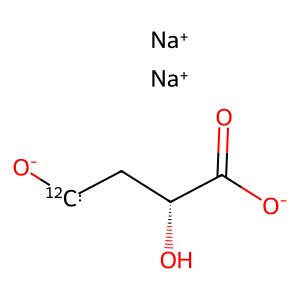

Resolving Trial 0


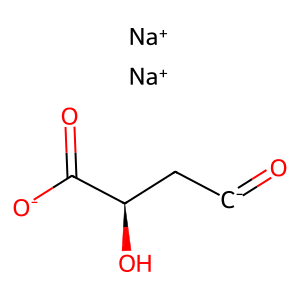

Charge, Isotope and Stereo Parent


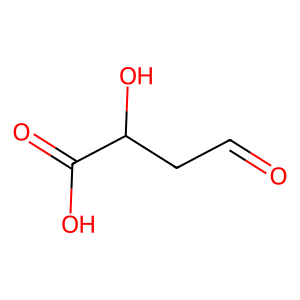

Tautomer Try 1


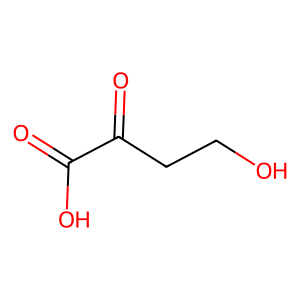

Tautomer Try 2


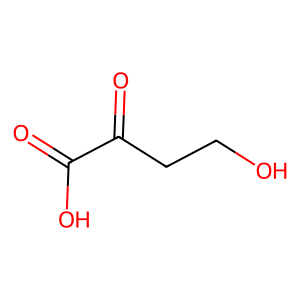

Tautomer Try 3


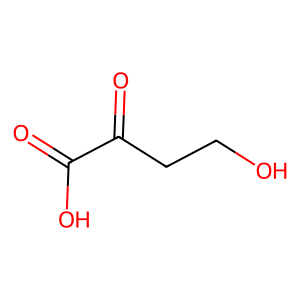

Final Rules


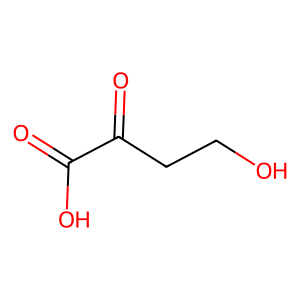

Resolving Trial 1


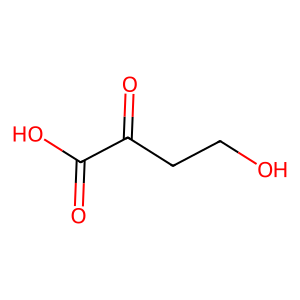

Charge, Isotope and Stereo Parent


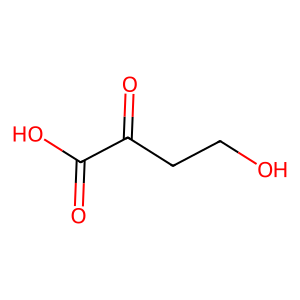

Tautomer Try 1


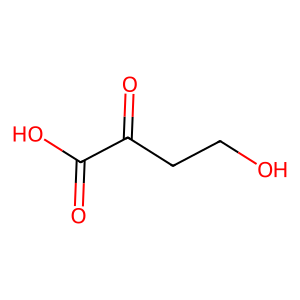

Tautomer Try 2


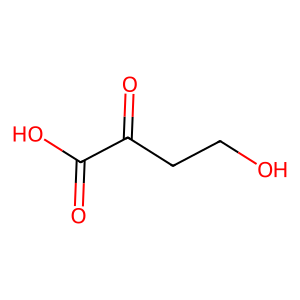

Tautomer Try 3


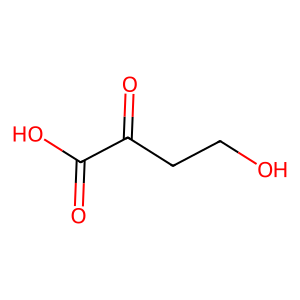

Final Rules


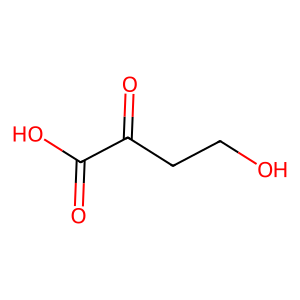

Rule finalised
We need to run Environment BioTransformation here from https://biotransformer.ca/new
Protonated SMILES


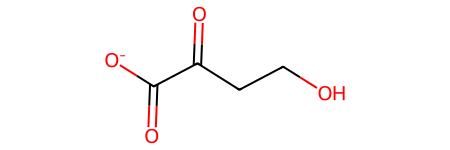

'O=C([O-])C(=O)CCO'

In [72]:
smiles_without_borders("[Na+].[Na+].[O-][12C]C[C@@H](O)C([O-])=O", pH=7)

In [27]:
mol = Chem.MolFromSmiles("CCCCOCN")

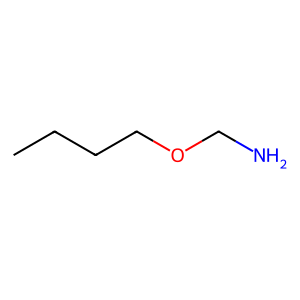

In [28]:
Draw.MolToImage(mol)

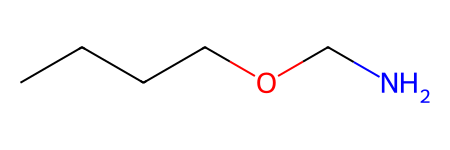

In [29]:
mol